# Agenda

1) Data extraction  
2) NLP for text cleansing  
3) EDA  
4) NLP based feature  
5) Vectorization > Topic model
6) Word embedding > PCA > Clustering  
7) Model selection with hyper parameter tuning  
8) Prediction  
9) Evaluation  

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
from wordcloud import WordCloud

# Load data

In [2]:
"""Load data from files"""
import glob as gl
import pandas as pd
import pathlib as pth


def load_file(path: str, load_all: bool = False, filter: str = None, sep: str = None, header: int = 0) -> pd.DataFrame:
    if pth.Path(path).is_file():
        if path.endswith(".csv"):
            dfs = pd.read_csv(path, header=header)
        elif path.endswith(".txt"):
            dfs = pd.read_csv(path, sep=sep, header=header)
        elif path.endswith(".xlsx"):
            dfs = pd.read_excel(path, header=header)
    elif pth.Path(path).is_dir() and load_all:
        df_list = []
        files = gl.glob(f"{path}/*")
        if filter:
            files = [i for i in files if filter in i]
        print("files to be loaded:", files)
        for file in files:
            if file.endswith(".csv"):
                df = pd.read_csv(file, low_memory=False, header=header)
                df_list.append(df)
            elif file.endswith(".txt"):
                df = pd.read_csv(file, sep=sep, header=header)
                df_list.append(df)
            elif file.endswith(".xlsx"):
                df = pd.read_excel(file, header=header)
                df_list.append(df)                
        dfs = pd.concat(df_list)
        dfs.reset_index(drop=True, inplace=True)
    elif pth.Path(path).is_dir() and not load_all:
        raise ValueError("load_all should be True")
    else:
        raise ValueError("error")

    return dfs

In [3]:
# Get contents from csv file
df = load_file(path="data/reviews_data.csv", load_all=False, header=0)

In [4]:
# Display first 5 rows of each df
df.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [5]:
# Check df information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


## Data preprocessing

In [6]:
# Drop name and Image_Liks > Not necessary columns and NA
df.drop(columns=["name", "Image_Links"], inplace=True)
df.dropna(axis=0, how="any", inplace=True)

In [7]:
# Break location into city and state
df[["City", "State"]] = df["location"].str.rsplit(",", n=1, expand=True).apply(lambda x: x.str.strip())
df["State"] = df["State"].str.replace(".", "")
df["State"] = df["State"].str.upper()
df.drop(columns=["location"], inplace=True)

In [8]:
# Date change to Date format and add year/month colmns
df["Date"] = df["Date"].str.replace("Reviewed", "").astype("datetime64[ns]")
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

In [9]:
# Check values of city and State
for i in ["City", "State"]:
    print(df[i].unique())

['Wichita Falls' 'Apopka' 'Cranberry Twp' 'Seattle' 'Gresham' 'Sunnyvale'
 'Spring Hill' 'Asheville' 'Reisterstown' 'Zionville' 'Long Beach'
 'Westerville' 'Fontana' 'Kapolei' 'Absecon' 'Atlanta' 'Hamilton'
 'Washington' 'Fairburn' 'Coquitlam' 'Haltom City' 'Phoenix' 'Davis'
 'West Roxbury' 'Homosassa' 'Mesquite' 'Spring Valley' 'Toronto'
 'Montreal' 'Silver Spring' 'Old Bridge' 'Pleasant Hill' 'Duffield'
 'Las Vegas' 'Johnson City' 'East Stroudsburg' 'Mission' 'Sloan'
 'Rocky Mount' 'Oshawa' 'Portland' 'Newnan' 'Santa Rosa' 'Beverly Hills'
 'Hasbrouck Heights' 'Franklin' 'Green Bay' 'Bristol' 'Springdale'
 'Encinitas' 'Whoville' 'Minneapolis' 'North Vancouver' 'Cocoa'
 'Fort Worth' 'Wadsworth' 'Chester' 'Morristown' 'Columbus' 'Wentzville'
 'Duluth' 'Lake Elsinore' 'Culpeper' 'Prescott' 'Chicago' 'Crystal Falls'
 'Longwood' 'Lithonia' 'Houston' 'Costa Mesa' 'Jackson' 'Englewood'
 'Oxenford' 'Toronto, Canada' 'Ephrata' 'Garland' 'Laguna' 'Oklahoma City'
 'Charlotte' 'Philadelphia' 'Toa

In [10]:
# Drop non-US records State name and change State name with XX format
remove_state = [None, "Other", "OTHER", "Saskatchewan", "NO OTHER LINE NEEDED", "UK", "Alberta"]
df = df[~df["State"].isin(remove_state)]

In [11]:
# Scraping State info
import requests
from bs4 import BeautifulSoup

url = "https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations"

req = requests.get(url)
if req.status_code == 200:
    page = req.content
    print("Connected")
else:
    print("Not connected")


Connected


In [12]:
# Parsing the page
soup = BeautifulSoup(page, "html.parser")

# Verifying tables and their classes
print('Classes of each table:')
for table in soup.find_all("table"):
    print(table.get("class"))

Classes of each table:
['wikitable']
['wikitable', 'sortable', 'sticky-header-multi', 'mw-datatable']
['wikitable']
['nowraplinks', 'mw-collapsible', 'mw-collapsed', 'navbox-inner']
['nowraplinks', 'hlist', 'mw-collapsible', 'mw-collapsed', 'navbox-inner']


In [13]:
# Looking for the table with the classes wikitable sortable sticky-table-head sticky-table-col1 mw-datatable
table = soup.find("table", class_="wikitable sortable sticky-header-multi mw-datatable")

In [14]:
# Defining of the dataframe
cols = ["Name", "Status_of_region", "USPS"]
wiki_df = pd.DataFrame(columns=["Name", "Status_of_region", "USPS"])

# Prepare lists of each column
name_list = []
sor_list = []
usps_list = []

# Collecting Ddata
for row in table.tbody.find_all("tr"):    
    # Find all data for each column
    columns = row.find_all("td")

    # Add up column value    
    if(columns != []):
        name_list.append(columns[0].text.strip())
        sor_list.append(columns[1].text.strip())
        usps_list.append(columns[5].text.strip())

data_dict = {"Name": name_list, "Status_of_region": sor_list, "USPS": usps_list}
add_df = pd.DataFrame.from_dict(data_dict)
wiki_df = pd.concat([wiki_df, add_df], ignore_index=True)
# Filter out Status of region like "State" and Keep "DC"
wiki_df = wiki_df[(wiki_df["Status_of_region"].str.contains("State")) | (wiki_df["USPS"] == "DC")]

In [15]:
# Check scrapped data
wiki_df

,Name,Status_of_region,USPS
1,Alabama,State,AL
2,Alaska,State,AK
3,Arizona,State,AZ
4,Arkansas,State,AR
5,California,State,CA
6,Colorado,State,CO
7,Connecticut,State,CT
8,Delaware,State,DE
9,District of Columbia,Federal district,DC
10,Florida,State,FL


In [16]:
# Replace State name into State code
for name, code in zip(wiki_df["Name"], wiki_df["USPS"]):
    df["State"] = df["State"].replace(name, code)

# Retain only US states
df = df[df["State"].isin(wiki_df["USPS"].values)]

In [17]:
# Rating to classifications; 1-2 Not satisfied, 3-5 Satisfied
df["Sentiment"] = df["Rating"].apply(lambda x: "Satisfied" if x >= 3 else "Not Satisfied")

In [18]:
# Check df
df

,Date,Rating,Review,City,State,Year,Month,Sentiment
0,2023-09-13,5.0,Amber and LaDonna at the Starbucks on Southwes...,Wichita Falls,TX,2023,9,Satisfied
1,2023-07-16,5.0,** at the Starbucks by the fire station on 436...,Apopka,FL,2023,7,Satisfied
2,2023-07-05,5.0,I just wanted to go out of my way to recognize...,Cranberry Twp,PA,2023,7,Satisfied
3,2023-05-26,5.0,Me and my friend were at Starbucks and my card...,Seattle,WA,2023,5,Satisfied
4,2023-01-22,5.0,I’m on this kick of drinking 5 cups of warm wa...,Gresham,OR,2023,1,Satisfied
...,...,...,...,...,...,...,...,...
699,2011-10-04,1.0,I have never been so rudely spoken to in such ...,Mayer,AZ,2011,10,Not Satisfied
700,2011-10-02,1.0,I ordered Via Starbucks coffee online. I recei...,Cotati,CA,2011,10,Not Satisfied
702,2011-08-24,1.0,"The bagel was ice cold, not cut and not toasted.",Ny,NY,2011,8,Not Satisfied
703,2011-08-15,1.0,"In the morning of Monday, August 15, 2011, at ...",La Puente,CA,2011,8,Not Satisfied


In [19]:
# Display texts for quick check
for i in range(len(df)):
    print(df.iloc[i, 2])

Amber and LaDonna at the Starbucks on Southwest Parkway are always so warm and welcoming. There is always a smile in their voice when they greet you at the drive-thru. And their customer service is always spot-on, they always get my order right and with a smile. I would actually give them more than 5 stars if they were available.
** at the Starbucks by the fire station on 436 in Altamonte Springs, FL made my day and finally helped me figure out the way to make my drink so I’d love it. She took time out to talk to me for 2 minutes to make my experience better than what I’m used to. It was much appreciated! I’ve had bad experiences one after another at the Starbucks that’s closest to me in my work building with my drinks not being great along with not great customer service from specific baristas. Niko was refreshing to speak to and pleasant. The drink was perfect! Store 11956
I just wanted to go out of my way to recognize a Starbucks employee Billy at the Franklin Park location! I was r

In [20]:
# Load SpaCy's small English language model
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-letters"
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenize
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove stopwords and lemmatize, ensuring tokens are valid & remove company name and coffee (common words)
    sw_mod = [i for i in nltk.corpus.stopwords.words("english") if i != "not"]
    stop_words = set(sw_mod)
    tokens = [
        token.lemma_ 
        for token in nlp(" ".join(tokens)) 
        if token.lemma_ and token.lemma_ not in stop_words and token.lemma_ not in ["starbuck", "starbucks", "coffee"]
    ]

    return ' '.join(tokens)

# Processing texts
df["Review_mod"] = df["Review"].apply(preprocess_text)

# Check df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 613 entries, 0 to 749
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        613 non-null    datetime64[ns]
 1   Rating      613 non-null    float64       
 2   Review      613 non-null    object        
 3   City        613 non-null    object        
 4   State       613 non-null    object        
 5   Year        613 non-null    int32         
 6   Month       613 non-null    int32         
 7   Sentiment   613 non-null    object        
 8   Review_mod  613 non-null    object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(5)
memory usage: 43.1+ KB


In [21]:
# Display texts for quick check; processed texts
for i in range(len(df)):
    print(df.iloc[i, 8])

amber ladonna southwest parkway always warm welcome always smile voice greet drivethru customer service always spoton always get order right smile I would actually give star available
fire station altamonte spring fl make day finally help I figure way make drink I love take time talk I minute make experience well I used much appreciated I bad experience one another close I work building drink not great along not great customer service specific barista niko refreshing speak pleasant drink perfect store
I want go way recognize employee billy franklin park location I run late work place order wrong location not make order smile make within second thank soo much I bad morning people like make world well place
I friend card not work thankful worker pay drink nice not seem bother pay drink make day make I look like fool card not work thank dillon shoreline wa safeway thank much dillon help support kindness I rate I could
I kick drinking cup warm water I work instacart right every location I 

In [22]:
# Quick comparison before and after
df[["Review", "Review_mod"]]

,Review,Review_mod
0,Amber and LaDonna at the Starbucks on Southwes...,amber ladonna southwest parkway always warm we...
1,** at the Starbucks by the fire station on 436...,fire station altamonte spring fl make day fina...
2,I just wanted to go out of my way to recognize...,I want go way recognize employee billy frankli...
3,Me and my friend were at Starbucks and my card...,I friend card not work thankful worker pay dri...
4,I’m on this kick of drinking 5 cups of warm wa...,I kick drinking cup warm water I work instacar...
...,...,...
699,I have never been so rudely spoken to in such ...,I never rudely speak matter I leave without dr...
700,I ordered Via Starbucks coffee online. I recei...,I order via online I receive email stock wareh...
702,"The bagel was ice cold, not cut and not toasted.",bagel ice cold not cut not toast
703,"In the morning of Monday, August 15, 2011, at ...",morning monday august coworker I stop buy usua...


# EDA

In [23]:
"""EDA modules"""
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class EDA:
    """Class for General EDA.

    variables
    ----------
    df: pd.DataFrame
    target_col: str
        Target column on dataframe (only one column)
        - This column would be defined if you want to explicitly compare to other features
    ----------
    """
    def __init__(self, df: pd.DataFrame, target_col: str = None) -> None:
        """Initialize variables and define columns."""
        self._df = df
        self._tgt_col = target_col
        self._num_cols = df.select_dtypes(include="number").columns
        self._cat_cols = df.select_dtypes(include=["object", "category"]).columns
        print("Numerical columns")
        print(self._num_cols)
        print("--------")
        print("Categorical columns")
        print(self._cat_cols)
        print("--------")
        print("Target column")

    def describe_df(self) -> None:
        """Describe dataframe; info, nunique, null ratio & describe."""
        print("Overall")
        print(self._df.info())
        print("--------")
        print("Unique value count")
        print(self._df.nunique())
        print("--------")
        print("Null value rate")
        print(self._df.isnull().sum()/len(self._df)*100)
        print("--------")
        print("Describe numerical columns")
        print(self._df.describe())
        print("--------")
        if len(self._cat_cols) > 0:
            print("Describe categorical columns")
            print(self._df.describe(include="object"))
            print("--------")

    def dist_plot(self) -> None:
        """Distribution plots: histgram, boxplot & violin plot.

        If target column defined, then plots will be generated except the target column.
        """
        if self._tgt_col:
            for col in [x for x in self._num_cols if x != self._tgt_col]:
                f, ax = plt.subplots(1,3,figsize=(12,3))
                sns.histplot(self._df, x=col, ax=ax[0], kde=True, bins=20, stat="percent", hue=self._tgt_col)
                sns.boxplot(self._df, x=col, hue=self._tgt_col, ax=ax[1])
                sns.violinplot(self._df, x=col, hue=self._tgt_col, ax=ax[2], alpha=0.3)
                plt.legend()
                plt.show()

        else:
            for col in self._num_cols:
                f, ax = plt.subplots(1,3,figsize=(12,3))
                sns.histplot(self._df, x=col, ax=ax[0], kde=True, bins=20, stat="percent")
                sns.boxplot(self._df, x=col, ax=ax[1])
                sns.violinplot(self._df, x=col, ax=ax[2], alpha=0.3)
                plt.show()

    def counter_plot(self) -> None:
        """Counter plots.

        If target column defined, then plots will be generated except the target column.
        """
        for col in self._cat_cols:
            f, ax = plt.subplots(1,1,figsize=(12,4))
            sns.countplot(data=self._df, x=col, ax=ax)
            x_labels_1 = [label.get_text() for label in ax.get_xticklabels()]
            ax.set_xticklabels(x_labels_1, rotation=45)
            plt.show()


    def pair_plot(self) -> None:
        """Pair plot"""
        if self._tgt_col:
            _ = sns.pairplot(self._df, hue=self._tgt_col)
        else:
            _ = sns.pairplot(self._df)

    def pie_plot_target(self) -> None:
        """Pie plot for target column."""
        tgt_counts = self._df[self._tgt_col].value_counts()

        plt.figure()
        plt.pie(tgt_counts, labels=tgt_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
        plt.title(f"Distribution of {self._tgt_col}")
        plt.show()

    def dist_plot_target(self) -> None:
        """Distribution plot for target column."""
        plt.figure()
        sns.histplot(self._df[self._tgt_col], kde=True)
        plt.show()

    def corr_plot(self) -> None:
        """Calculate Pearson correlation among numerical columns and plot it."""
        df_corr = self._df.corr(numeric_only=True)
        mask = np.tril(np.ones(df_corr.shape),k = -1).astype(bool)
        df_corr_fil = df_corr.where(mask)

        plt.figure(figsize=(16,16))
        sns.heatmap(df_corr_fil, annot=True, cmap="crest", fmt=".2f", linewidths=0.01)
        plt.show()

        plt.figure(figsize = (16,16))
        mask = df_corr_fil.where(abs(df_corr_fil) > 0.9).isna()
        sns.heatmap(df_corr_fil, annot=True, cmap="crest", fmt=".2f", linewidths=0.01, mask=mask)
        plt.show()


    def plot_all(self) -> None:
        """Execute all functions."""
        self.describe_df()
        # If Binary value on the target column, then create a pie plot; otherwise histogram.
        if self._tgt_col:
            if len(self._df[self._tgt_col].unique()) > 2:
                self.dist_plot_target()
            else:
                self.pie_plot_target()
        self.dist_plot()
        self.counter_plot()

## General EDA

In [24]:
# Load EDA class
eda = EDA(df[[i for i in df.columns if i not in ["Review", "Review_mod"]]], target_col="Rating")

Numerical columns
Index(['Rating', 'Year', 'Month'], dtype='object')
--------
Categorical columns
Index(['City', 'State', 'Sentiment'], dtype='object')
--------
Target column


In [25]:
# Describe df
eda.describe_df()

Overall
<class 'pandas.core.frame.DataFrame'>
Index: 613 entries, 0 to 749
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       613 non-null    datetime64[ns]
 1   Rating     613 non-null    float64       
 2   City       613 non-null    object        
 3   State      613 non-null    object        
 4   Year       613 non-null    int32         
 5   Month      613 non-null    int32         
 6   Sentiment  613 non-null    object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(3)
memory usage: 33.5+ KB
None
--------
Unique value count
Date         542
Rating         5
City         437
State         48
Year          14
Month         12
Sentiment      2
dtype: int64
--------
Null value rate
Date         0.0
Rating       0.0
City         0.0
State        0.0
Year         0.0
Month        0.0
Sentiment    0.0
dtype: float64
--------
Describe numerical columns
                            

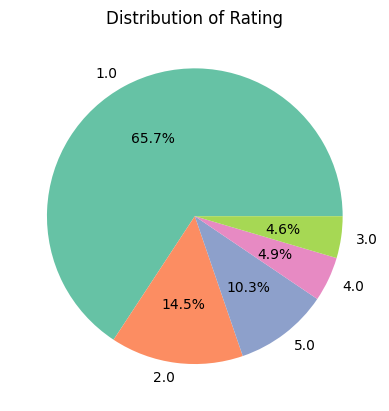

In [26]:
# Target label distribution
eda.pie_plot_target()

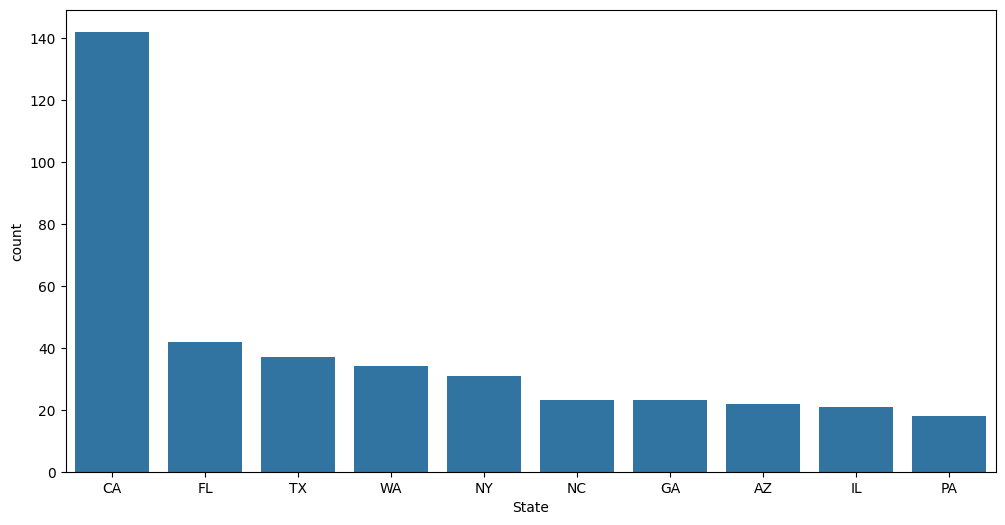

In [27]:
# Plot top 10 of review count per State
plt.figure(figsize=(12,6))
sns.countplot(df, x="State", order = df["State"].value_counts().iloc[:10].index)
plt.show()

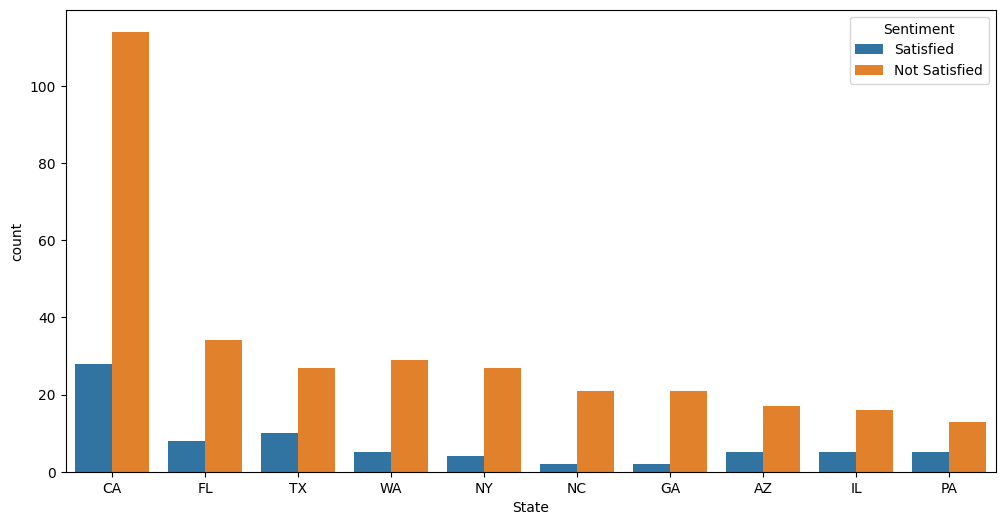

In [28]:
# Plot top 10 of review count per State and sentiment
plt.figure(figsize=(12,6))
sns.countplot(df, x="State", hue="Sentiment", order=df["State"].value_counts().iloc[:10].index)
plt.show()

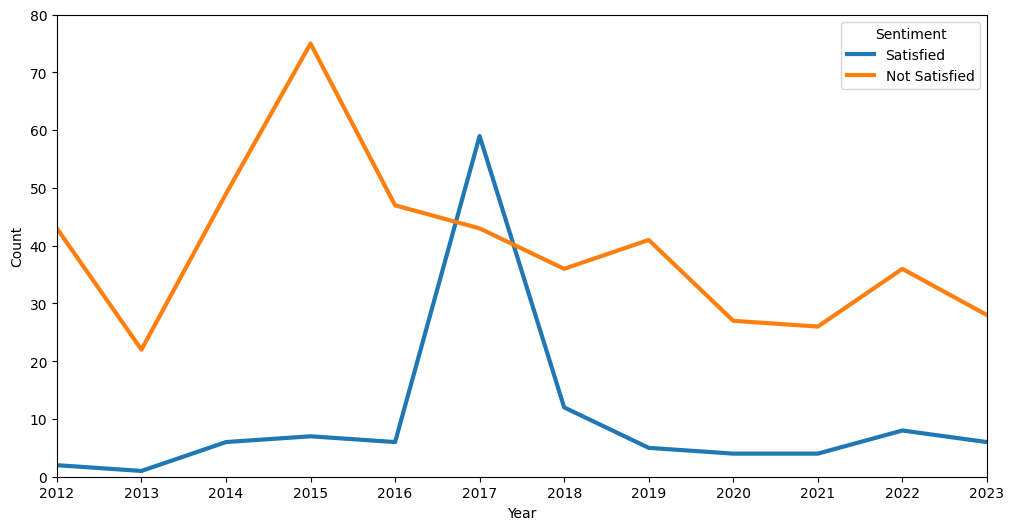

In [29]:
# trend
df_grp_year = df.groupby(["Year", "Sentiment"], as_index=False)["Rating"].count()
plt.figure(figsize=(12,6))
sns.lineplot(df_grp_year, x="Year", y="Rating", hue="Sentiment", lw=3)
plt.xlim([2012, 2023])
plt.xticks(range(2012,2024))
plt.xlabel("Year")
plt.ylim([0,80])
plt.ylabel("Count")
plt.show()

In [30]:
# Check texts for CA and negative sentiment
for i in df[(df["Sentiment"] == "Not Satisfied") & (df["State"] == "CA")].index:
    for j in df.loc[i, "Review"].split("."):
        if "order" in j:
            print(j.strip())

They have purposefully removed them in order to save electricity, a slap in the face to us loyal customers who spend gobs of money on their overpriced drink and food already
When ordering this morning I clearly asked for a Venti drink
After I waited for a while, they brought my Grande drink and I told the barista that I had ordered a Venti
She said that they had charged me for a Grande and I said "OK, but I ordered a Venti" the Barista "not happy" started making my drink again and went to the cashier and asked her something which I couldn't hear
The person who takes order does not smile and is rude
Finally, I went back to the order area to order water, the new barista was polite and addressed the request
When Starbucks changed the "rewards" to "stars", they eliminated the unlimited free purchases, now if you order more than one item, you don't get the discount on multiple purchases, as you did with the old "rewards" program, and there was no notice of any kind advising that the unlimit

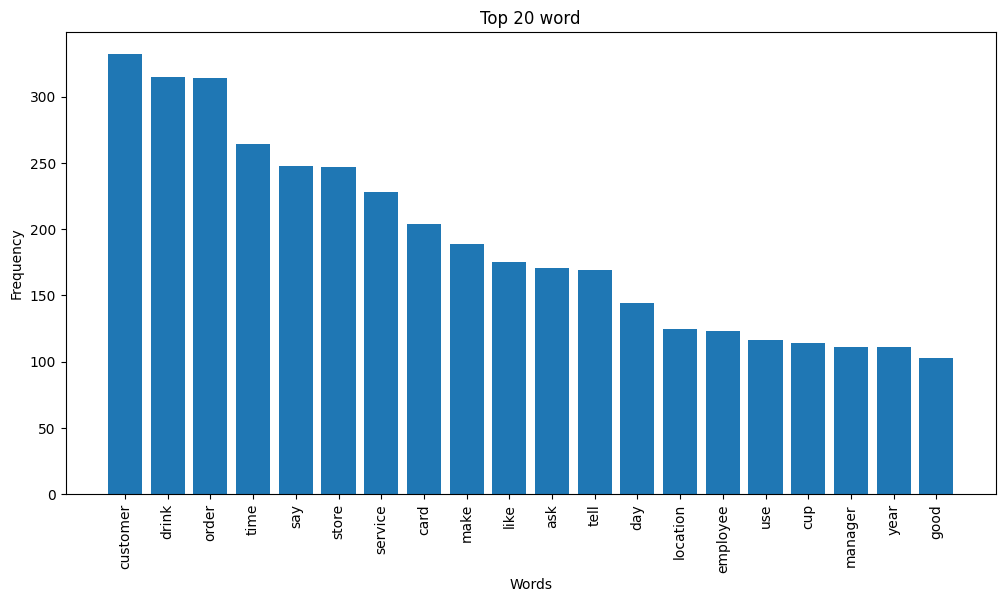

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to plot top n words
def plot_top_words(text_data, n=20):
    vectorizer = CountVectorizer(stop_words="english", max_features=n)
    bag_of_words = vectorizer.fit_transform(text_data)
    sum_words = bag_of_words.sum(axis=0)
    # count frequency by word; not unique count per review
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    words, freqs = zip(*words_freq)
    plt.figure(figsize=(12, 6))
    plt.bar(words, freqs)
    plt.title(f"Top {n} word")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()
    
# Plot top words
plot_top_words(df["Review_mod"])

In [32]:
# Function to plot word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=1000, height=500, background_color="white", colormap="cubehelix").generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Extract texts for each sentiment category
positive_text = ' '.join(df[(df["Sentiment"] == "Satisfied") & (df["State"] == "CA")]["Review_mod"])
negative_text = ' '.join(df[(df["Sentiment"] == "Not Satisfied") & (df["State"] == "CA")]["Review_mod"])

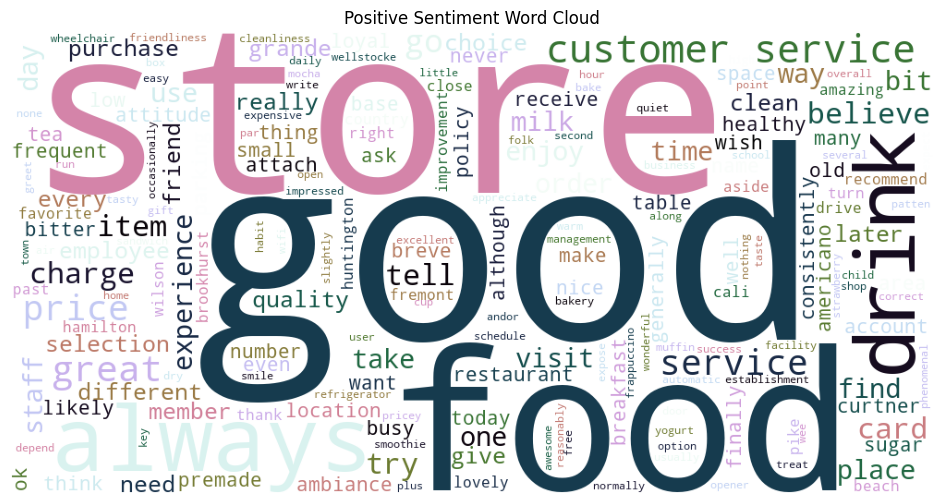

In [33]:
# Plot wordcloud for positive text
plot_wordcloud(positive_text, 'Positive Sentiment Word Cloud')

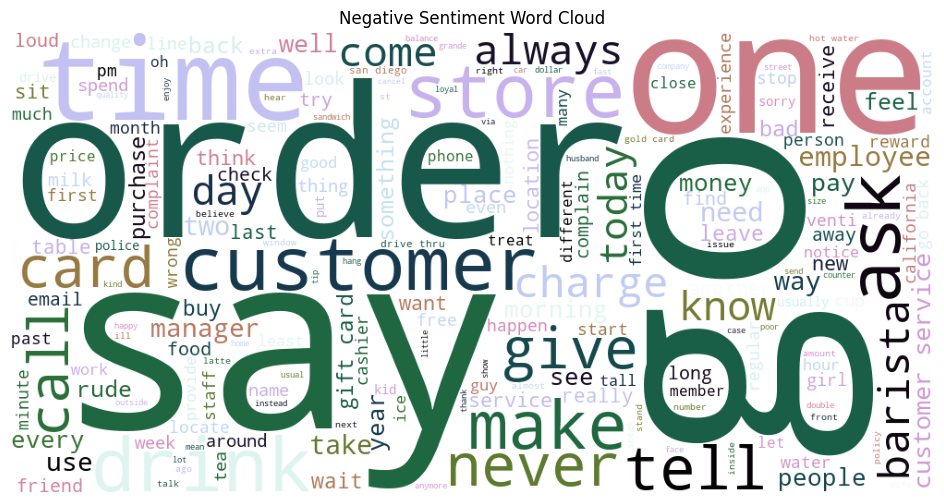

In [34]:
# Plot wordcloud for negative text
plot_wordcloud(negative_text, 'Negative Sentiment Word Cloud')

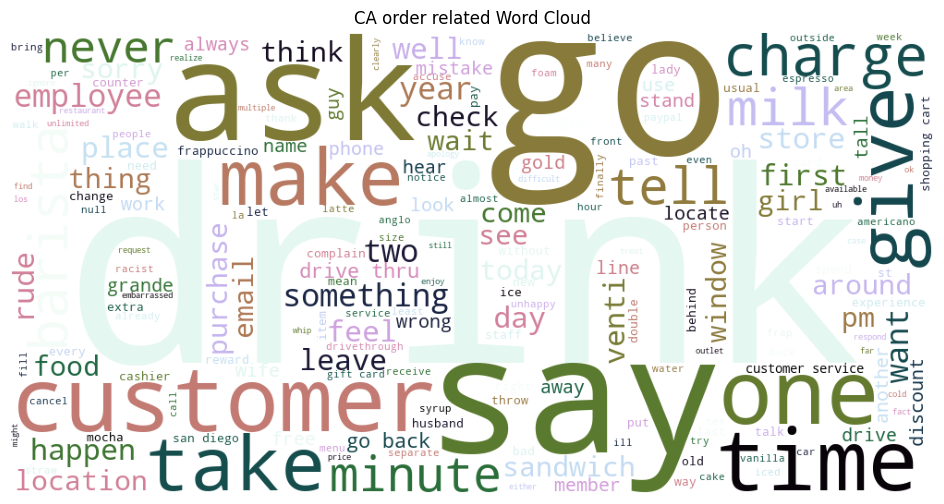

In [35]:
# Plot wordcloud for specific condition; negative, state=CA, review includes order
ca_order_text = ' '.join(df[(df["Sentiment"] == "Not Satisfied") & (df["State"] == "CA") & (df["Review_mod"].str.contains("order"))]["Review_mod"])
ca_order_text = re.sub("order", "", ca_order_text)
plot_wordcloud(ca_order_text, 'CA order related Word Cloud')

# Data prep & Feature engineering

In [36]:
from sklearn.model_selection import train_test_split

# Features and Labels
X = df[["Review", "Review_mod"]]
y = df["Sentiment"].map({"Satisfied": 1, "Not Satisfied": 0})


In [37]:
import string

# NLP based feature; character, word counting, word density, punctuation counting
X = X.copy()
X["char_count"] = X["Review"].apply(lambda x: len(x.replace(" ", "")))  # exclude white spaces
X["word_count"] = X["Review"].apply(lambda x: len(x.split()))
X["word_density"] = X["char_count"] / (X["word_count"] + 1)
X["punctuation_count"] = X["Review"].apply(lambda x: len("".join(i for i in x if i in string.punctuation)))

# Display df
X

,Review,Review_mod,char_count,word_count,word_density,punctuation_count
0,Amber and LaDonna at the Starbucks on Southwes...,amber ladonna southwest parkway always warm we...,272,60,4.459016,7
1,** at the Starbucks by the fire station on 436...,fire station altamonte spring fl make day fina...,451,105,4.254717,9
2,I just wanted to go out of my way to recognize...,I want go way recognize employee billy frankli...,280,72,3.835616,4
3,Me and my friend were at Starbucks and my card...,I friend card not work thankful worker pay dri...,356,86,4.091954,17
4,I’m on this kick of drinking 5 cups of warm wa...,I kick drinking cup warm water I work instacar...,332,74,4.426667,7
...,...,...,...,...,...,...
699,I have never been so rudely spoken to in such ...,I never rudely speak matter I leave without dr...,792,197,4.000000,24
700,I ordered Via Starbucks coffee online. I recei...,I order via online I receive email stock wareh...,162,37,4.263158,3
702,"The bagel was ice cold, not cut and not toasted.",bagel ice cold not cut not toast,39,10,3.545455,2
703,"In the morning of Monday, August 15, 2011, at ...",morning monday august coworker I stop buy usua...,238,60,3.901639,10


In [38]:
# Apply a train-test split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

## Vectorization

In [39]:
# TF-IDF word-level
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(analyzer="word", max_features=4000)
print(tfidf_vec)

train_X_tfidf = tfidf_vec.fit_transform(train_X["Review_mod"])
test_X_tfidf = tfidf_vec.transform(test_X["Review_mod"])

# Check output
print("TF-IDF Features:")
print(f"Number of features: {train_X_tfidf.shape[1]}")
print(f"Sparsity: {1 - train_X_tfidf.nnz / (train_X_tfidf.shape[0] * train_X_tfidf.shape[1]):.2%}")
print(train_X_tfidf.nnz)
print(train_X_tfidf.shape)

TfidfVectorizer(max_features=4000)
TF-IDF Features:
Number of features: 3370
Sparsity: 98.93%
17697
(490, 3370)


In [40]:
# Convert np.array to pd.df for validation
train_X_np = train_X_tfidf.toarray()
train_X_df = pd.DataFrame(train_X_np, columns=tfidf_vec.get_feature_names_out())
train_X_df

,aa,abdominal,ability,able,abroad,absolutely,absorb,abusive,abysmal,ac,...,yogurt,york,young,yous,youth,yrs,yuba,yukon,yummy,zero
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.075409,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
486,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
487,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Counting word in raw data
word = "customer"
counting = 0
idxs = []

for idx, sentence in enumerate(train_X["Review_mod"]):
    if len(re.findall(r"\bcustomer\b(?=\s|$)", sentence)) > 0:
        idxs.append(idx)
        counting += 1

print(idxs)
print(counting)

[0, 2, 5, 6, 7, 9, 13, 16, 19, 25, 31, 34, 36, 37, 39, 44, 45, 50, 51, 58, 62, 63, 66, 69, 76, 77, 83, 84, 85, 86, 87, 90, 93, 94, 100, 103, 104, 109, 113, 116, 117, 120, 122, 123, 124, 126, 127, 132, 133, 134, 135, 136, 137, 140, 148, 150, 151, 154, 161, 164, 166, 169, 174, 177, 178, 186, 190, 191, 196, 197, 203, 211, 217, 218, 219, 221, 223, 226, 230, 239, 241, 242, 244, 246, 248, 251, 253, 254, 260, 261, 262, 264, 266, 277, 279, 283, 284, 285, 289, 290, 291, 294, 296, 297, 298, 300, 303, 305, 307, 308, 313, 314, 315, 319, 321, 322, 323, 326, 330, 333, 340, 344, 345, 347, 348, 350, 353, 356, 357, 360, 361, 367, 369, 376, 381, 383, 393, 398, 399, 400, 401, 402, 406, 408, 411, 414, 415, 416, 418, 421, 422, 424, 426, 427, 431, 440, 445, 446, 447, 448, 449, 450, 454, 456, 464, 465, 466, 477, 483, 484, 487, 489]
172


In [42]:
# Counting word in vectorized data
print(train_X_df[train_X_df["customer"]!=0]["customer"].index)
idxs_comp = list(train_X_df[train_X_df["customer"]!=0]["customer"].index)

Index([  0,   2,   5,   6,   7,   9,  13,  16,  19,  25,
       ...
       454, 456, 464, 465, 466, 477, 483, 484, 487, 489],
      dtype='int64', length=172)


In [43]:
# Assert
idxs == idxs_comp

True

In [44]:
# Topic modeling
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=10, learning_method="online", max_iter=10, random_state=42)
train_X_lda = lda_model.fit_transform(train_X_tfidf)
test_X_lda = lda_model.transform(test_X_tfidf)

In [45]:
# view the topic models
topic_word = lda_model.components_
vocab = tfidf_vec.get_feature_names_out()

n_top_words = 10
topic_summaries = []
print('Group Top Words')
print('-----', '-'*80)
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    top_words = ' '.join(topic_words)
    topic_summaries.append(top_words)
    print('  %3d %s' % (i, top_words))

Group Top Words
----- --------------------------------------------------------------------------------
    0 easy address car glass convenient cinnamon dog hospital store brother
    1 customer discount realize breakfast one travel job guy like employee
    2 not go get drink order customer card service time say
    3 lyric overwhelm unusually crowded edinger internment cemetery mute cipher squat
    4 strong leave make flat store drink ready inexperienced not work
    5 luke example bet panhandler track confusion chaos race exciting nicki
    6 wade hampton greer carolina south crew anywhere group awesome star
    7 collaboration doppio impolite mismanagement extraordinary phipps demonstrate exceptionally atlanta alleviate
    8 organic identical honest yukon not package tall day one holiday
    9 cream not sleeve hot customer one really order charge service


In [46]:
# check output vector
train_X_lda

array([[0.01275172, 0.01275172, 0.8852345 , ..., 0.01275172, 0.01275172,
        0.01275172],
       [0.01460691, 0.01460691, 0.86853782, ..., 0.01460691, 0.01460691,
        0.01460692],
       [0.01366724, 0.01366724, 0.87699482, ..., 0.01366725, 0.01366724,
        0.01366724],
       ...,
       [0.02330791, 0.02330791, 0.79022884, ..., 0.02330791, 0.02330791,
        0.02330791],
       [0.01501376, 0.01501377, 0.86487611, ..., 0.01501377, 0.01501376,
        0.01501377],
       [0.01461608, 0.01461608, 0.8684553 , ..., 0.01461608, 0.01461608,
        0.01461608]])

## Word embedding

In [47]:
# Check modified review just for check later
train_X["Review_mod"]

434    worst bad customer service experience I encoun...
403    week I unable order shopping cart literally br...
138    lower standard cleanliness presentation moral ...
94     january I order egg white egg bite bite two to...
26     I special need son need wait access van store ...
                             ...                        
81     I order mint frappuccino not freeze I return f...
125    radio loud could not hear person behind counte...
320    staff friendly fast get want staff make accomp...
505    I want tall americano espresso double shot I u...
121    I contact customer service ask give one day re...
Name: Review_mod, Length: 490, dtype: object

In [48]:
# word embedding with Word2Vec
from gensim.models import Word2Vec

# Word2Vec
def train_word2vec(sentences):
    tokenized_sentences = [nltk.tokenize.word_tokenize(sentence) for sentence in sentences]
    model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=5, workers=4)
    return model

def get_sentence_vector(model, sentence):
    words = nltk.tokenize.word_tokenize(sentence)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(100)
    return np.mean(word_vectors, axis=0)

word2vec_model = train_word2vec(train_X["Review_mod"])
train_X_w2v = np.array([get_sentence_vector(word2vec_model, sentence) for sentence in train_X["Review_mod"]]).astype(np.float64)
test_X_w2v = np.array([get_sentence_vector(word2vec_model, sentence) for sentence in test_X["Review_mod"]]).astype(np.float64)

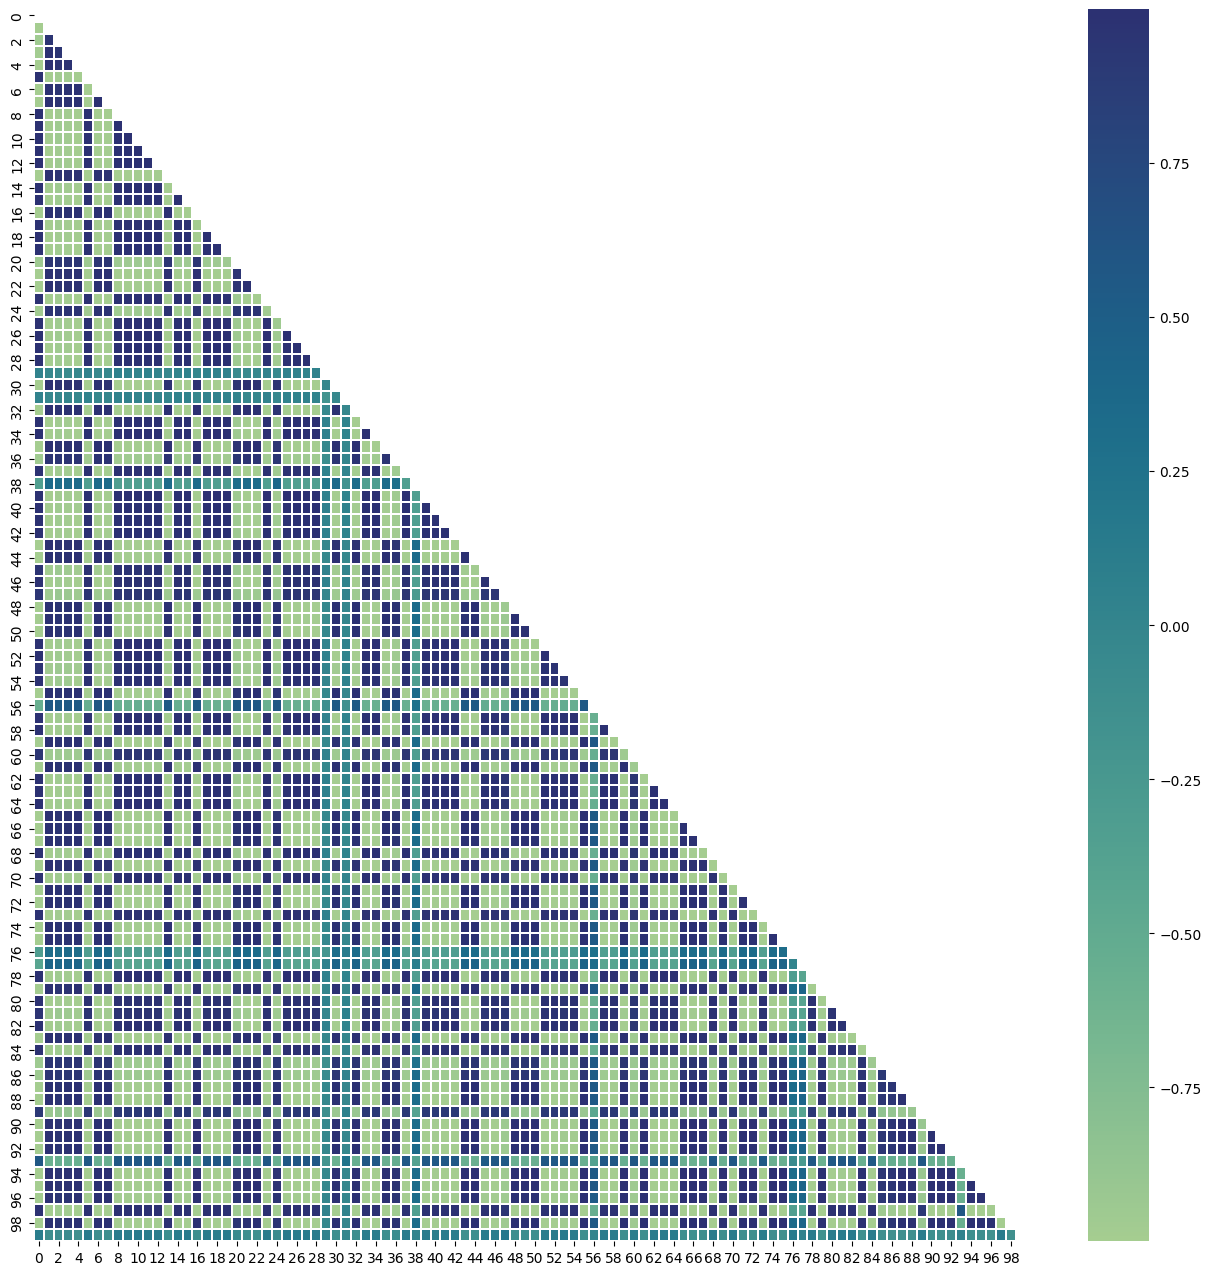

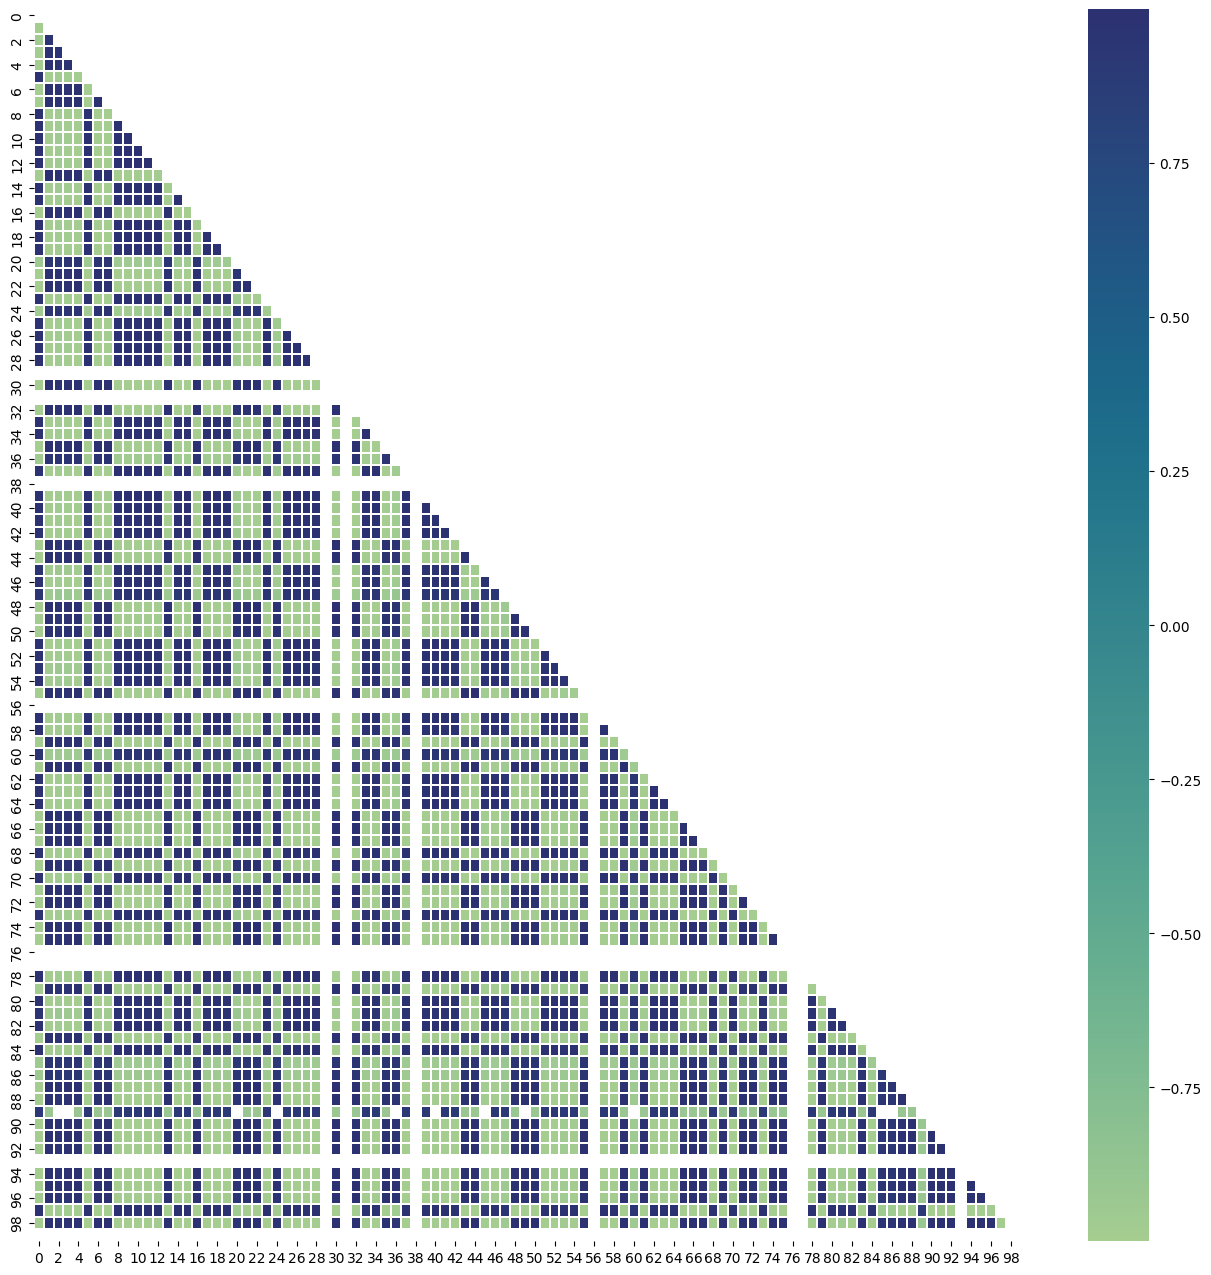

In [49]:
# corr for all cols
train_X_w2v_df = pd.DataFrame(train_X_w2v)
train_X_w2v_df_corr = train_X_w2v_df.corr()
mask = np.tril(np.ones(train_X_w2v_df_corr.shape),k = -1).astype(bool)
df_corr_fil = train_X_w2v_df_corr.where(mask)

plt.figure(figsize=(16,16))
sns.heatmap(df_corr_fil, cmap="crest", linewidths=0.01)
plt.show()

plt.figure(figsize = (16,16))
mask = df_corr_fil.where(abs(df_corr_fil) > 0.9).isna()
sns.heatmap(df_corr_fil, cmap="crest", linewidths=0.01, mask=mask)
plt.show()

In [50]:
# EDA for Word2Vec
print("Word2Vec Features:")
print(f"Vector size: {train_X_w2v.shape[1]}")
print("Sample vector:", train_X_w2v[0])

Word2Vec Features:
Vector size: 100
Sample vector: [-1.82658225e-01  1.95699111e-01  4.43671085e-02  6.53344765e-02
  1.77632257e-01 -5.28784156e-01  1.60932094e-01  8.20481300e-01
 -3.09740752e-01 -1.33698449e-01 -1.14367403e-01 -4.25058782e-01
 -1.05661876e-01  2.26301193e-01 -1.13578446e-01 -1.61615491e-01
  1.84857339e-01 -1.25125140e-01 -1.57160938e-01 -6.28691137e-01
  3.81389856e-02  1.37184367e-01  1.76548019e-01 -2.16826469e-01
  5.23342192e-02 -1.31751731e-01 -2.32196033e-01 -2.09687456e-01
 -4.65376407e-01  2.41090180e-04  3.37255299e-01  8.35768587e-04
  2.87754625e-01 -3.19578171e-01 -1.69140384e-01  3.57407570e-01
  5.00370301e-02 -4.67498302e-01  4.90843551e-03 -4.48903978e-01
 -9.96778682e-02 -2.49805912e-01 -2.63619661e-01  1.36140823e-01
  2.11653545e-01 -6.14003092e-02 -2.94655889e-01 -4.06357870e-02
  2.83279777e-01  9.80481431e-02  1.26000255e-01 -1.89061955e-01
 -1.61927953e-01 -4.80897203e-02 -9.81217325e-02  1.53896704e-01
  5.07365493e-03 -2.27636188e-01 -3.658

## Feature engineering

In [51]:
# PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=5)
train_X_pca = pca.fit_transform(train_X_w2v)
test_X_pca = pca.transform(test_X_w2v)


PCA:
Explained variance ratio: [9.97674227e-01 2.57629209e-04 1.44253278e-04 1.36862704e-04
 9.22742972e-05]


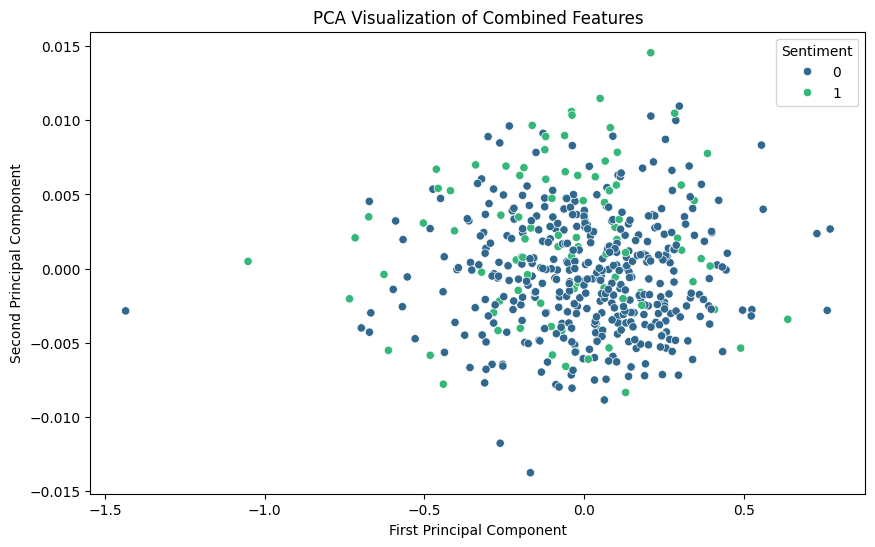

In [52]:
# EDA for PCA
print("\nPCA:")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_X_pca[:, 0], y=train_X_pca[:, 1], hue=train_y, palette='viridis')
plt.title("PCA Visualization of Combined Features")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

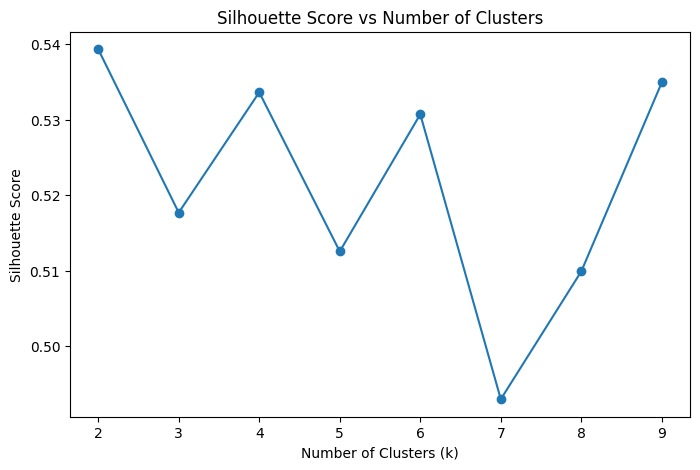

In [53]:
# K-means Clustering on PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test different values of k
sil_scores = []
range_k = range(2, 10)

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(train_X_pca)
    score = silhouette_score(train_X_pca, labels)
    sil_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range_k, sil_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

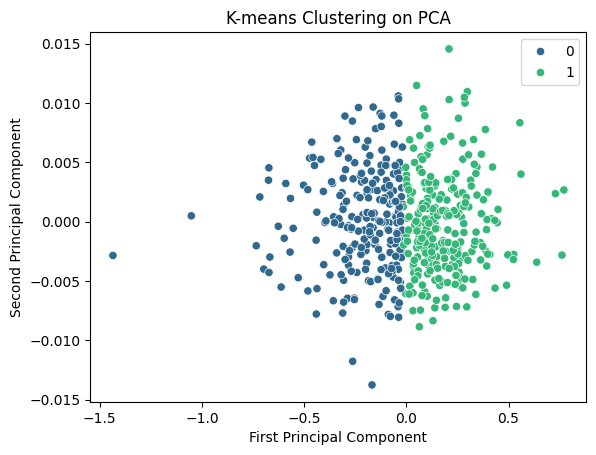

In [54]:
# K-means Clustering on PCA
from sklearn.cluster import KMeans

kmeans_pca = KMeans(n_clusters=2, random_state=42, init='k-means++')
train_clusters_pca = kmeans_pca.fit_predict(train_X_pca)
test_clusters_pca = kmeans_pca.predict(test_X_pca)

# EDA for K-means
sns.scatterplot(x=train_X_pca[:, 0], y=train_X_pca[:, 1], hue=train_clusters_pca, palette='viridis')
plt.title("K-means Clustering on PCA")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

In [55]:
# normalization of NLP based feature; similar scale to other features
from sklearn.preprocessing import MinMaxScaler
NLP_cols  = ["char_count", "word_count", "word_density", "punctuation_count"]

scaler = MinMaxScaler()

train_X_nlp = scaler.fit_transform(train_X[NLP_cols])
test_X_nlp = scaler.transform(test_X[NLP_cols])

In [56]:
# display outputs
train_X_nlp

array([[0.83763441, 0.73611111, 0.49154877, 0.57377049],
       [0.68709677, 0.625     , 0.44663045, 0.45901639],
       [0.5483871 , 0.52314815, 0.3877551 , 0.14754098],
       ...,
       [0.18387097, 0.15277778, 0.51627137, 0.06557377],
       [0.57204301, 0.59722222, 0.28924352, 0.19672131],
       [0.63655914, 0.61111111, 0.38235294, 0.32786885]])

In [57]:
# Combine all features

X_train_final = np.hstack(
    [train_X_tfidf.toarray(),
    train_X_lda,
    train_X_w2v,
    train_X_pca,
    # train_clusters_pca.reshape(-1, 1),  # clustering may not work well
    train_X_nlp]
)

X_test_final = np.hstack(
    [test_X_tfidf.toarray(),
    test_X_lda,
    test_X_w2v,
    test_X_pca,
    # test_clusters_pca.reshape(-1, 1),  # clustering may not work well
    test_X_nlp]
)

In [58]:
sampling = "over"

if sampling == "over":
    # over sampling
    from imblearn.combine import SMOTETomek
    from imblearn.over_sampling import RandomOverSampler
    from collections import Counter

    print("over sampling")
    counter = Counter(train_y)
    print('Before', counter)

    # oversampling the train dataset using SMOTE
    # smt = SMOTETomek(sampling_strategy=0.5, random_state=42)
    smt = RandomOverSampler(sampling_strategy=1, random_state=42)
    X_train_final_sm, train_y_sm = smt.fit_resample(X_train_final, train_y)

    counter = Counter(train_y_sm)
    print('After', counter)

elif sampling == "under":

    # under sampling
    from imblearn.under_sampling import RandomUnderSampler
    from collections import Counter

    print("under sampling")
    counter = Counter(train_y)
    print('Before', counter)

    undersampler = RandomUnderSampler(sampling_strategy=1, random_state=42)
    X_train_final_und, train_y_und = undersampler.fit_resample(X_train_final, train_y)

    counter = Counter(train_y_und)
    print('After', counter)

    X_train_final_sm = X_train_final_und
    train_y_sm = train_y_und

else:
    print("no over/under sampling")
    X_train_final_sm = X_train_final
    train_y_sm = train_y

print("X_train shape: ", X_train_final_sm.shape)
print("train_y shape: ", train_y_sm.shape)

over sampling
Before Counter({0: 397, 1: 93})
After Counter({1: 397, 0: 397})
X_train shape:  (794, 3489)
train_y shape:  (794,)


# Modelling: Hyper param tuning & Evaluation

## Define models - classification

In [59]:
import lightgbm as lgb
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# define models as dict
models = {
    "logistic": LogisticRegression(max_iter=2000),
    "svc": SVC(),
    "knn": KNeighborsClassifier(),
    "random_forest": RandomForestClassifier(),
    "lightgbm": lgb.LGBMClassifier(),
    "xgboost": xgb.XGBClassifier(),
}

In [60]:
# Define DNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

optimizer = Adam()

DNN_model = Sequential()
DNN_model.add(Dense(32, activation="relu", input_shape=(X_train_final_sm.shape[1], )))
DNN_model.add(Dense(64, activation="relu", input_shape=(X_train_final_sm.shape[1], )))
DNN_model.add(Dense(1, activation='sigmoid'))

DNN_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

DNN_model.summary()

/Users/leehy0816/anaconda3/envs/bootcamp/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │       111,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,857 (444.75 KB)

 Trainable params: 113,857 (444.75 KB)

 Non-trainable params: 0 (0.00 B)

## hyper parameter tuning with grid search CV 

In [61]:
params = {
    "logistic": {},
    "svc": {
        "kernel": ["rbf"],
        "C": [1, 10],
        "gamma": ["scale", "auto"],
    },
    "knn": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "p": [1, 2, 3]
    },
    "random_forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 15],
    },
    "lightgbm": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [5, 10, 15],
        "verbose": [-1],
    },
    "xgboost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [5, 10, 15],
    },
}

In [62]:
"""Modules of repeated usage"""
import numpy as np
import pandas as pd

from typing import Union
from sklearn.model_selection import GridSearchCV


def hyperparam_tuning_gs(model, params: dict, X: pd.DataFrame, y: Union[pd.DataFrame, pd.Series, np.array], scoring: str, cv: int = None) -> dict:
    """Hyper parameter tuning by grid search with cross validation.

    Variables
    ----------
    model: Estimator
        Model estimater (initialized one not trained model)
    params: dict
        Hyper paramters
    X: pd.DataFrame
        Dataframe only with feature columns
    y: pd.DataFrame | pd.Series |
        Dataframe only with feature columns
    cv: int
        Number of split for X-validation
    ----------

    Outputs
    ----------
    best_params: dict
        Hyper parameter from the best model
    ----------
    """
    if cv:
        # use when we specific fold numbers for cv
        gridsearch = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring=scoring)
        gridsearch.fit(X, y)
    else:
        # cv = 5 (default) will be applied.
        gridsearch = GridSearchCV(estimator=model, param_grid=params, scoring=scoring)
        gridsearch.fit(X, y)

    # store best result
    best_est = gridsearch.best_estimator_
    best_params = gridsearch.best_params_
    best_score = gridsearch.best_score_

    print("best params:", best_params)
    print("best_score:", best_score)

    # return best estimator, params and score
    return best_est, best_params, best_score

In [63]:
import time
from sklearn.metrics import accuracy_score

best_models = {}
scoring = "accuracy"  # objective metrics

# loop grid search for parameter tuning
for model, estimator in models.items():
    print(f"Model: {model}")
    start_time = time.time()
    if len(params[model]) == 0:
        print("Hyperparmeters not defined. Training with default params.")
        estimator.fit(X_train_final_sm, train_y_sm)
        pred_y = estimator.predict(X_train_final_sm)
        end_time = time.time()
        score = accuracy_score(train_y_sm, pred_y)
        print("best_score:", score)
        best_models[model] = {"estimator": estimator, "params": {}, "score": score}
        print("Execution time: %s seconds" %(end_time - start_time))
        print(f"-----------")
        continue
    print(params[model])
    best_est, best_params, best_score = hyperparam_tuning_gs(estimator, params[model], X_train_final_sm, train_y_sm, scoring)
    end_time = time.time()
    best_models[model] = {"estimator": best_est, "params": best_params, "score": best_score}
    print("Execution time: %s seconds" %(end_time - start_time))
    print(f"-----------")


Model: logistic
Hyperparmeters not defined. Training with default params.
best_score: 0.9848866498740554
Execution time: 0.1494429111480713 seconds
-----------
Model: svc
{'kernel': ['rbf'], 'C': [1, 10], 'gamma': ['scale', 'auto']}
best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
best_score: 0.9861475997133986
Execution time: 9.69075608253479 seconds
-----------
Model: knn
{'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]}
best params: {'n_neighbors': 3, 'p': 3, 'weights': 'distance'}
best_score: 0.8678051110580368
Execution time: 57.18356919288635 seconds
-----------
Model: random_forest
{'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}
best params: {'max_depth': 15, 'n_estimators': 50}
best_score: 0.9546532919353554
Execution time: 9.744837999343872 seconds
-----------
Model: lightgbm
{'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 10, 15], 'verbose': [-1]}
best params: {'learning_rate': 0.1, 'max_depth

In [64]:
"""Model Evaluation"""

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    confusion_matrix,
    classification_report,
    recall_score,
    precision_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc,
    roc_auc_score
)

def score(y_act, y_pred, model):
    """Evluate models.

    Variables
    ----------
    y_act: actual values (answers)
    y_pred: predicted values by model
    model: model speices (Regression or Classification)
    ----------

    Outputs
    ----------
    if Regression, then r2, mse & mae
    if Classification, then accuracy, confusion matrix & report
    ----------
    """
    # if model = Regression, then r2, mse and mae will be returned
    if "RegModel" in model:
        r2 = r2_score(y_act, y_pred)
        mse = mean_squared_error(y_act, y_pred)
        mae = mean_absolute_error(y_act, y_pred)

        return r2, mse, mae

    # if model = classification, then acc, confusion matrix and report will be returned
    elif "ClsModel" in model:
        acc = accuracy_score(y_act, y_pred)
        cm = confusion_matrix(y_act, y_pred)
        cr = classification_report(y_act, y_pred)
        
        return acc, cm, cr

    # if model not defined correctly, raise error
    else:
        raise ValueError("Model is not a Regression or a Classification model")

In [65]:
params = {"validation_split": 0.2, "batch_size": 32, "epochs": 20, "verbose": 1}

# Fit model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

history = DNN_model.fit(
    X_train_final_sm,
    train_y_sm,
    callbacks=[early_stopping],
    **params
)
# predictions = np.argmax(model.predict(X_train_final_sm), axis=-1)
y_train_pred = DNN_model.predict(X_train_final_sm)
y_train_pred = [0 if val < 0.5 else 1 for val in y_train_pred]

acc, cm, report = score(train_y_sm, y_train_pred, "ClsModel")
print(acc)
print(cm)
print(report)

best_models["DNN"] = {"estimator": DNN_model, "params": params, "score": acc}

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5576 - loss: 0.6797 - val_accuracy: 0.0000e+00 - val_loss: 0.9891
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6050 - loss: 0.6229 - val_accuracy: 0.0063 - val_loss: 0.9543
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7647 - loss: 0.4848 - val_accuracy: 0.5723 - val_loss: 0.6763
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9060 - loss: 0.3665 - val_accuracy: 0.8679 - val_loss: 0.4466
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.2235 - val_accuracy: 0.9434 - val_loss: 0.2540
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.1325 - val_accuracy: 1.0000 - val_loss: 0.1309
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0756 - val_accuracy: 1.0000 - val_loss: 0.0956
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0446 - val_accuracy: 1.0000 - val_l

<Figure size 640x480 with 0 Axes>

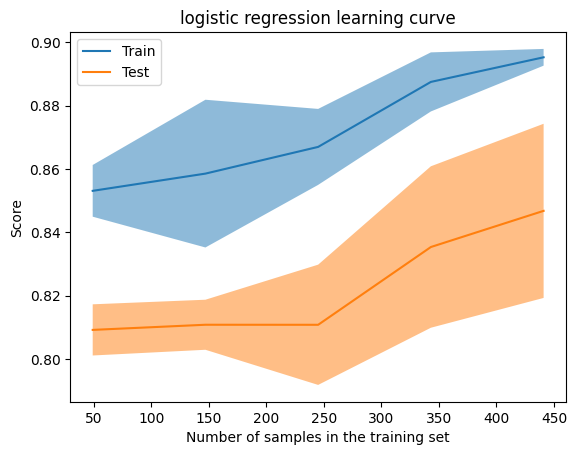

<Figure size 640x480 with 0 Axes>

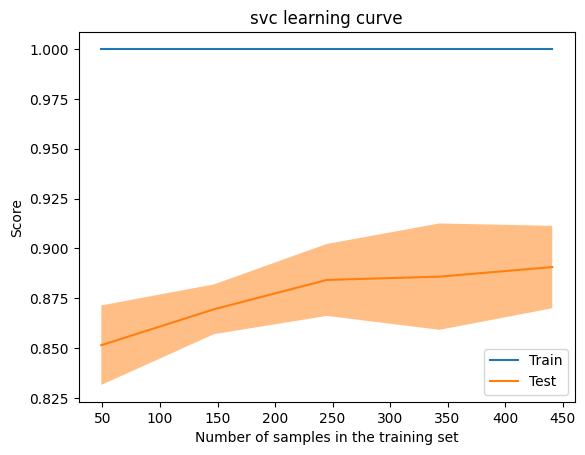

<Figure size 640x480 with 0 Axes>

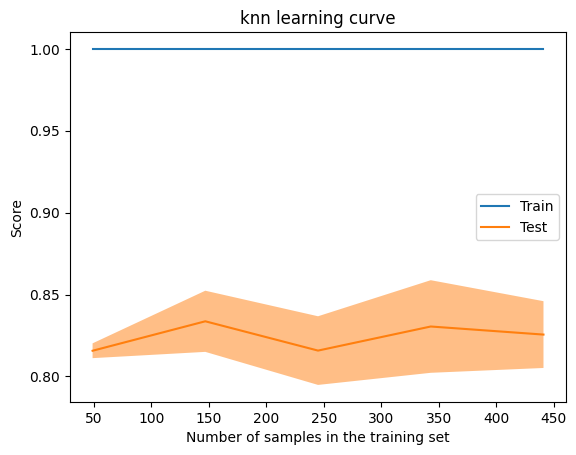

<Figure size 640x480 with 0 Axes>

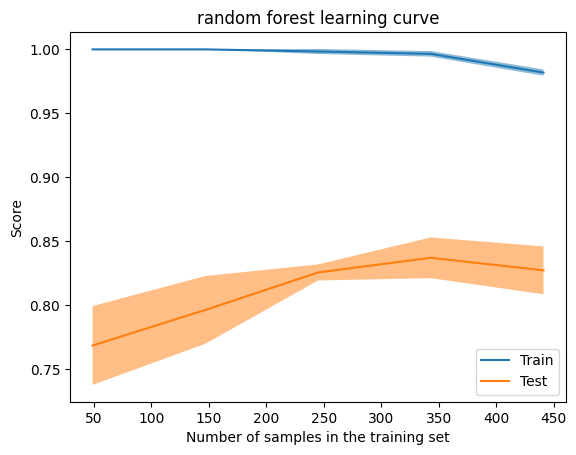

In [66]:
# learning curves
XX = np.concatenate([X_train_final, X_test_final], axis=0)
YY = pd.concat([train_y, test_y], axis=0)

from sklearn.model_selection import LearningCurveDisplay

plt.figure()
_ = LearningCurveDisplay.from_estimator(best_models["logistic"]["estimator"], XX, YY, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9], cv=5)
plt.title("logistic regression learning curve")
plt.show()

plt.figure()
_ = LearningCurveDisplay.from_estimator(best_models["svc"]["estimator"], XX, YY, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9], cv=5)
plt.title("svc learning curve")
plt.show()

plt.figure()
_ = LearningCurveDisplay.from_estimator(best_models["knn"]["estimator"], XX, YY, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9], cv=5)
plt.title("knn learning curve")
plt.show()

plt.figure()
_ = LearningCurveDisplay.from_estimator(best_models["random_forest"]["estimator"], XX, YY, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9], cv=5)
plt.title("random forest learning curve")
plt.show()

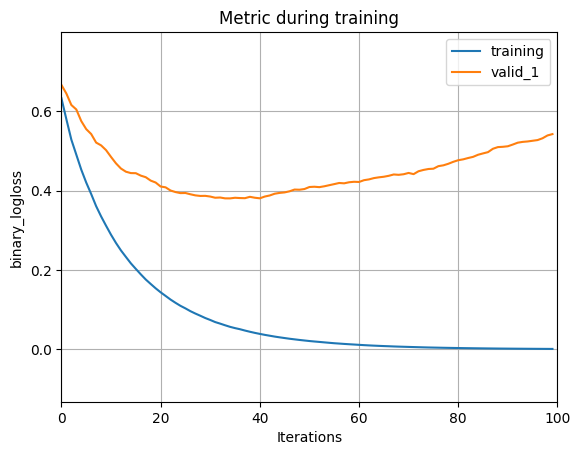

In [67]:
# Learning curve (LGBM)
mdl = best_models["lightgbm"]["estimator"]
mdl.fit(X_train_final_sm, train_y_sm, eval_set=[(X_train_final_sm, train_y_sm), (X_test_final, test_y)])
_ = lgb.plot_metric(mdl)

[0]	validation_0-logloss:0.61387	validation_1-logloss:0.65269
[1]	validation_0-logloss:0.54950	validation_1-logloss:0.61699
[2]	validation_0-logloss:0.49528	validation_1-logloss:0.59286
[3]	validation_0-logloss:0.44812	validation_1-logloss:0.56917
[4]	validation_0-logloss:0.40661	validation_1-logloss:0.54948
[5]	validation_0-logloss:0.37050	validation_1-logloss:0.52328
[6]	validation_0-logloss:0.33747	validation_1-logloss:0.50926
[7]	validation_0-logloss:0.30930	validation_1-logloss:0.48915
[8]	validation_0-logloss:0.28425	validation_1-logloss:0.47534
[9]	validation_0-logloss:0.26096	validation_1-logloss:0.46210
[10]	validation_0-logloss:0.24203	validation_1-logloss:0.45895
[11]	validation_0-logloss:0.22402	validation_1-logloss:0.44632
[12]	validation_0-logloss:0.20740	validation_1-logloss:0.43974
[13]	validation_0-logloss:0.19205	validation_1-logloss:0.43277
[14]	validation_0-logloss:0.17829	validation_1-logloss:0.42850
[15]	validation_0-logloss:0.16600	validation_1-logloss:0.41827
[1

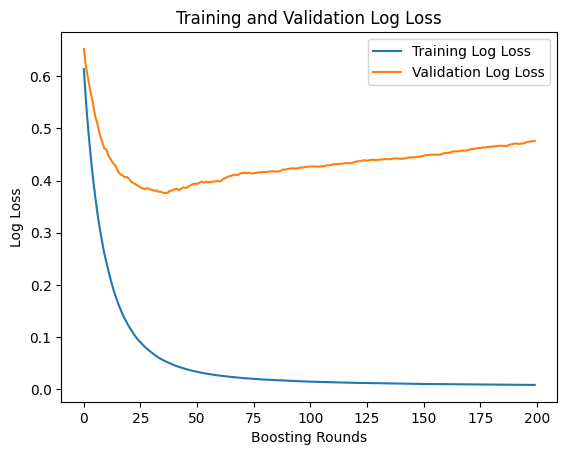

In [68]:
# Learning curve (XGB)
mdl = best_models["xgboost"]["estimator"]
mdl.fit(X_train_final_sm, train_y_sm, eval_set=[(X_train_final_sm, train_y_sm), (X_test_final, test_y)])

# Retrieve evaluation results
evals_result = mdl.evals_result()
epochs = range(len(evals_result['validation_0']['logloss']))
plt.plot(epochs, evals_result['validation_0']['logloss'], label='Training Log Loss')
plt.plot(epochs, evals_result['validation_1']['logloss'], label='Validation Log Loss')
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("Training and Validation Log Loss")
plt.legend()
plt.show()

In [ ]:
# DNN would be the best model according to accuracy: LGBM & XGB looks overfit

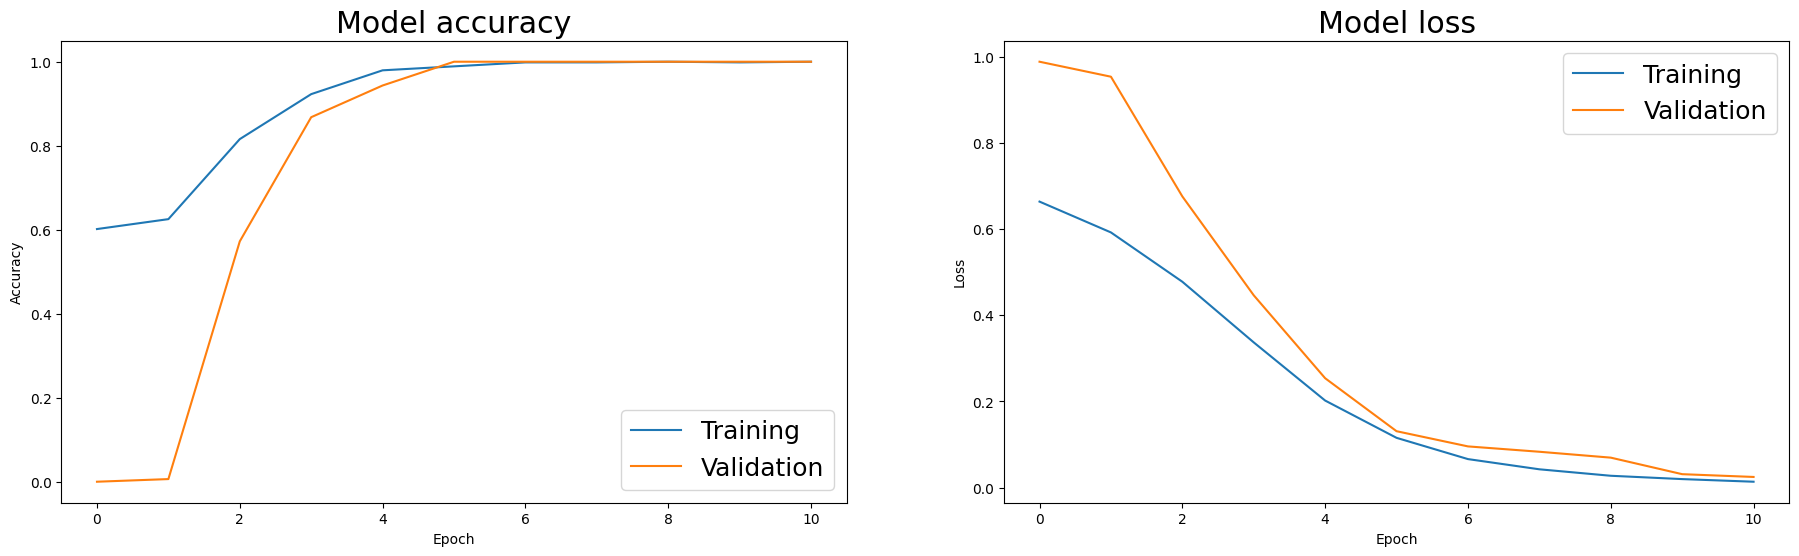

In [69]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(history.history['accuracy'], label = 'Training')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

In [70]:
# check test metrics

print("Test data")

for m in models.keys():
    start_time = time.time()
    mdl = best_models[m]["estimator"]
    mdl_pred_y = mdl.predict(X_test_final)
    end_time = time.time()
    
    acc, cm, report = score(test_y, mdl_pred_y, "ClsModel")

    print(f"-----------")
    print("model:", m)
    print("acc:", acc)
    print("confusion matrix:", cm)
    print("repot:", report)
    print("Execution time: %s seconds" %(end_time - start_time))
    print(f"-----------")

Test data
-----------
model: logistic
acc: 0.8455284552845529
confusion matrix: [[82 13]
 [ 6 22]]
repot:               precision    recall  f1-score   support

           0       0.93      0.86      0.90        95
           1       0.63      0.79      0.70        28

    accuracy                           0.85       123
   macro avg       0.78      0.82      0.80       123
weighted avg       0.86      0.85      0.85       123

Execution time: 0.004729032516479492 seconds
-----------
-----------
model: svc
acc: 0.9024390243902439
confusion matrix: [[91  4]
 [ 8 20]]
repot:               precision    recall  f1-score   support

           0       0.92      0.96      0.94        95
           1       0.83      0.71      0.77        28

    accuracy                           0.90       123
   macro avg       0.88      0.84      0.85       123
weighted avg       0.90      0.90      0.90       123

Execution time: 0.09306693077087402 seconds
-----------
-----------
model: knn
acc: 0.772357

In [71]:
start_time = time.time()
y_test_pred = best_models["DNN"]["estimator"].predict(X_test_final)
end_time = time.time()
# y_test_pred = DNN_model.predict(X_test_final)
predictions = [0 if val < 0.5 else 1 for val in y_test_pred]
predictions

acc, cm, report = score(test_y, predictions, "ClsModel")
print(acc)
print(cm)
print(report)
print("Execution time: %s seconds" %(end_time - start_time))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.8861788617886179
[[91  4]
 [10 18]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.82      0.64      0.72        28

    accuracy                           0.89       123
   macro avg       0.86      0.80      0.82       123
weighted avg       0.88      0.89      0.88       123

Execution time: 0.043263912200927734 seconds


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


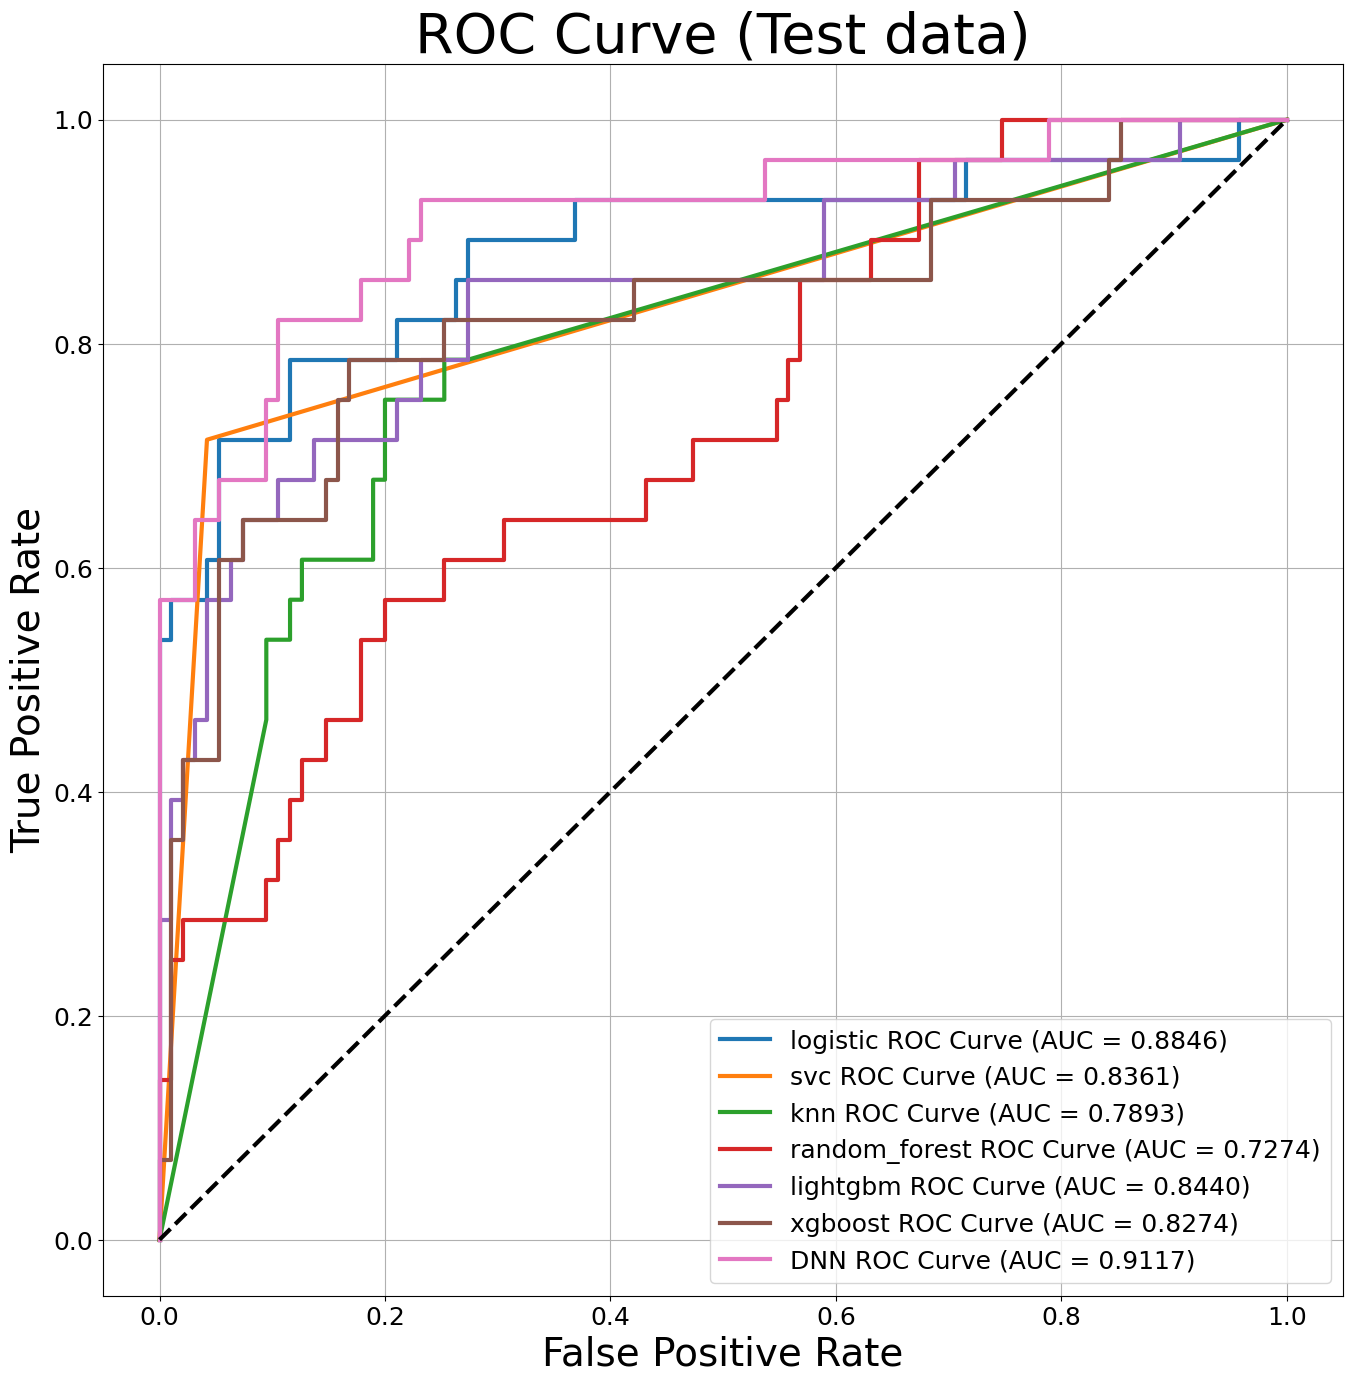

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(16,16))
for m in best_models.keys():
    if m in ["svc", "DNN"]:
        probabilities = best_models[m]["estimator"].predict(X_test_final)
    else:    
        probabilities = best_models[m]["estimator"].predict_proba(X_test_final)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(test_y, probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{m} ROC Curve (AUC = {roc_auc:.4f})', lw=3)

plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=3)  # Random guess line
plt.xlabel('False Positive Rate', fontsize=28)
plt.ylabel('True Positive Rate', fontsize=28)
plt.title('ROC Curve (Test data)', fontsize=40)
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Model Selection

In [73]:
# choose one best model based on score
best_model_key = max(best_models, key=lambda k: best_models[k]["score"])
selected_model = best_models[best_model_key]["estimator"]
if best_model_key != "DNN":
    print("Selected model:", best_model_key)
    print("Params for model:", selected_model.get_params())
    print("Score of model:", best_models[best_model_key]["score"])
else:
    print("Selected model:", best_model_key)
    print("Params for model:", best_models[best_model_key]["params"])
    print("Score of model:", best_models[best_model_key]["score"])

Selected model: DNN
Params for model: {'validation_split': 0.2, 'batch_size': 32, 'epochs': 20, 'verbose': 1}
Score of model: 0.9987405541561712


# Prediction

In [74]:
# prediction with best model
pred_y = selected_model.predict(X_test_final)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


In [75]:
# test data metrics

if best_model_key != "DNN":
    acc, cm, cr = score(test_y, pred_y, "ClsModel")

    print("accuracy:", acc)
    print("confusion matrix:", cm)
    print("report:", cr)
else:
    predictions = [0 if val < 0.5 else 1 for val in pred_y]
    predictions

    acc, cm, report = score(test_y, predictions, "ClsModel")
    print(acc)
    print(cm)
    print(report)

0.8861788617886179
[[91  4]
 [10 18]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.82      0.64      0.72        28

    accuracy                           0.89       123
   macro avg       0.86      0.80      0.82       123
weighted avg       0.88      0.89      0.88       123



In [76]:
"""Model Evaluation"""

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    confusion_matrix,
    classification_report,
    recall_score,
    precision_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc,
    roc_auc_score
)

def cls_summary_report(y_act, y_pred, y_proba):
    if isinstance(y_act, pd.Series):
        actual = y_act.values.astype(int)
    prediction = y_pred.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, y_proba)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, y_proba)
    average_precision = average_precision_score(actual, y_proba)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, y_proba)
    roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')

    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()

    return (accuracy_, precision_, recall_, roc_auc_)

<Figure size 1600x1600 with 0 Axes>

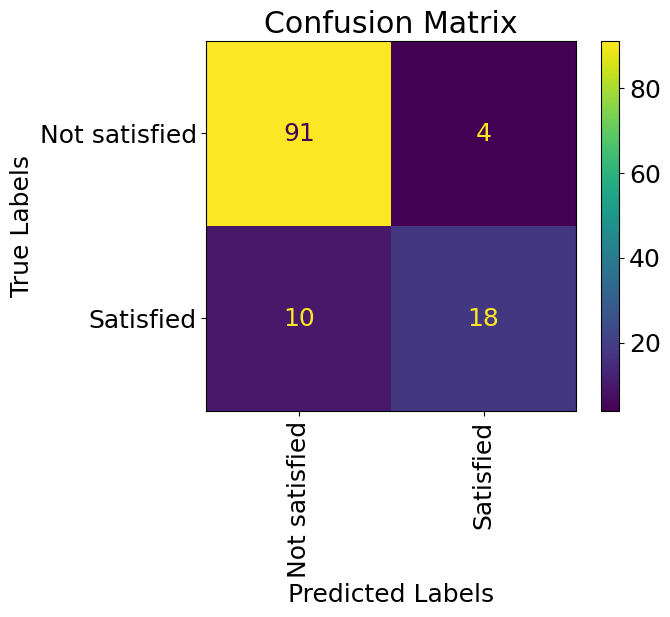

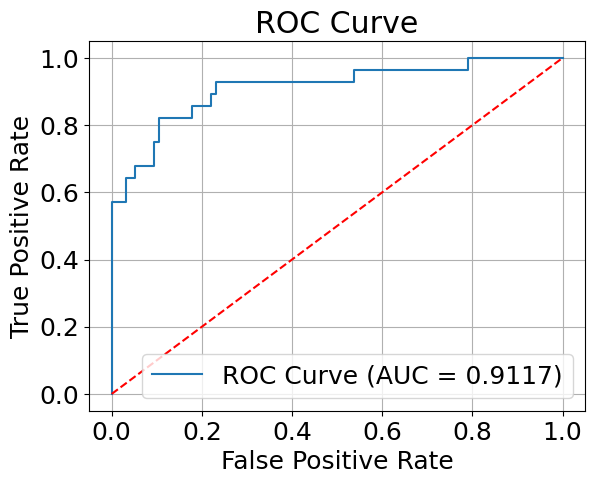

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

if best_model_key != "DNN":
    probabilities = selected_model.predict_proba(X_test_final)[:, 1]
    cls_summary_report(test_y, pred_y, probabilities)
else:
    cm = confusion_matrix(test_y, predictions)

    from sklearn.metrics import ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not satisfied", "Satisfied"])

    plt.figure(figsize=(16,16))
    disp.plot(xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    fpr, tpr, thresholds = roc_curve(test_y, pred_y)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()